In [21]:
import pandas as pd
import pickle
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

from scripts.extract_supported_versions import extract_supported_versions


In [22]:
# Обучение тестовой модели, что эти параметры из ранее выбранных являются самыми полезными
columns_to_keep = [
    "user_agent",
    "tls.extensions",
    "tls.ja3",
    "tls.peetprint_hash",
    "http2.akamai_fingerprint",
    "tcpip.ip.ttl",
    "tcpip.tcp.mss",
    "tcpip.tcp.window",
    "os_prediction.highest"
]

raw_df = pd.read_json('../raw_data/fingerprints_with_os_checked.json', lines=True)
raw_df = raw_df.to_dict(orient='records')
raw_df_exp = pd.json_normalize(raw_df, sep='_', max_level=None)

# Группировка по IP и проверка уникальных user_agents для каждого IP
conflicting_ips = raw_df_exp.groupby('ip')['user_agent'].nunique()
conflicting_ips = conflicting_ips[conflicting_ips > 1]

# Для каждого IP, где есть несколько user_agent, оставим только первую запись
df_cleaned = raw_df_exp[~raw_df_exp['ip'].isin(conflicting_ips.index)]  # Убираем строки с конфликтующими IP
df_cleaned = pd.concat([df_cleaned, raw_df_exp[raw_df_exp['ip'].isin(conflicting_ips.index)].drop_duplicates(subset=['ip'])])

columns_to_keep_normalized = [col.replace(".", "_") for col in columns_to_keep]

display(df_cleaned.head(1))

df = df_cleaned[columns_to_keep_normalized]
df.loc[:, "tls_supported_versions"] = df['tls_extensions'].apply(extract_supported_versions)

# Очищаем от 'tls_extensions' и пропусков
df = df.copy()
df.drop(columns=['tls_extensions'], inplace=True)
df.dropna(inplace= True)

# Создаем множество bool столбцов - объединение всех TLS версий
one_hot = df["tls_supported_versions"].explode().reset_index(drop=True).str.get_dummies().astype(bool)
df = df.drop(columns=["tls_supported_versions"]).join(one_hot)

display(df.head(5))

,ip,http_version,method,user_agent,js_fingerprint_fingerprint,js_fingerprint_fingerprints_persistentFp,js_fingerprint_fingerprints_uniqueFp,js_fingerprint_profile_applePay,js_fingerprint_profile_attributionsourceid,js_fingerprint_profile_audioContext,...,os_prediction_scores_Linux,os_prediction_platform_mismatch,blacklist_info_blacklist_info_ip,blacklist_info_blacklist_info_TotalBlacklists,blacklist_info_blacklist_info_CountFoundIn,blacklist_info_blacklist_info_FoundIn,tcpip_ip_df,tcpip_tcp_ack,tcpip_tcp_urp,js_fingerprint
0,165.227.55.199,h2,POST,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,1.541781e+09,2.250950e+09,1.541781e+09,"[-1, None]","[-1, None]","[0, 35.73833402246237]",...,3.93,True,165.227.55.199,10,2,"[b.barracudacentral.org, bb.barracudacentral.org]",NaN,NaN,NaN,NaN


/tmp/ipykernel_11149/1454978031.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "tls_supported_versions"] = df['tls_extensions'].apply(extract_supported_versions)


,user_agent,tls_ja3,tls_peetprint_hash,http2_akamai_fingerprint,tcpip_ip_ttl,tcpip_tcp_mss,tcpip_tcp_window,os_prediction_highest,0300,TLS 1.0,...,TLS_GREASE (0x6a6a),TLS_GREASE (0x7a7a),TLS_GREASE (0x8a8a),TLS_GREASE (0x9a9a),TLS_GREASE (0xaaaa),TLS_GREASE (0xbaba),TLS_GREASE (0xcaca),TLS_GREASE (0xdada),TLS_GREASE (0xeaea),TLS_GREASE (0xfafa)
0,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,"771,4865-4867-4866-49195-49199-52393-52392-491...",fea33d3783ae74d495240377b44baa68,"1:65536,4:131072,5:16384|12517377|3:0:0:201,5:...",45.0,1460.0,64240.0,Linux,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Mozilla/5.0 (Linux; Android 8.0.0; SM-G955U Bu...,"771,4865-4866-4867-49195-49199-49196-49200-523...",8ad9325e12f531d2983b78860de7b0ec,"1:65536,2:0,4:6291456,6:262144|15663105|0|m,a,s,p",46.0,1366.0,59220.0,Linux,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Mozilla/5.0 (compatible; AhrefsBot/7.0; +http:...,"771,4865-4866-4867-49195-49199-49196-49200-523...",d3adf83b0154a3dce2a78ec296fcbfa4,"1:65536,2:0,4:6291456,6:262144|15663105|0|m,a,s,p",58.0,1460.0,65535.0,Android,False,False,...,False,False,True,False,False,False,False,False,False,False
3,Mozilla/5.0 (iPhone; CPU iPhone OS 17_2 like M...,"771,4865-4866-4867-49196-49195-52393-49200-491...",b2bafdc69377086c3416be278fd21121,"2:0,4:2097152,3:100|10485760|0|m,s,p,a",48.0,1412.0,65535.0,iOS,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Mozilla/5.0 (compatible; AhrefsBot/7.0; +http:...,"771,4865-4866-4867-49195-49199-49196-49200-523...",d3adf83b0154a3dce2a78ec296fcbfa4,"1:65536,2:0,4:6291456,6:262144|15663105|0|m,a,s,p",58.0,1460.0,65535.0,Android,False,False,...,False,False,False,False,False,False,False,False,False,False


In [23]:
# Векторизируем тестовые параметры, чтобы модель могла с ними работать
X = df.drop(columns=['os_prediction_highest'])
vectorizer = ColumnTransformer(
    transformers=[
        ('user_agent_tfidf', TfidfVectorizer(), 'user_agent'),
        ('tls_ja3_tfidf', TfidfVectorizer(), 'tls_ja3'),
        ('tls_peetprint_hash_tfidf', TfidfVectorizer(), 'tls_peetprint_hash'),
        ('http2_akamai_fingerprint_tfidf', TfidfVectorizer(), 'http2_akamai_fingerprint'),
    ],
    remainder='passthrough'
)
X_transformed = vectorizer.fit_transform(X)
X = pd.DataFrame(X_transformed.toarray(), columns=vectorizer.get_feature_names_out())
with open("../vectorizer/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

In [24]:
# Используем LabelEncoder, чтобы закодировать название ОС
encoder = LabelEncoder()
df["os_encoded"] = encoder.fit_transform(df["os_prediction_highest"])

# Посмотрим, как преобразовались метки
print(dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))
y = df["os_encoded"]
df.to_csv('../clean_data/data.csv')
df.to_json('../clean_data/data.json')

{'Android': np.int64(0), 'Linux': np.int64(1), 'Mac OS': np.int64(2), 'Windows': np.int64(3), 'iOS': np.int64(4)}


In [25]:
# X = X.drop(columns=['user_agent_tfidf__x86_64']) data leakage????
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

dtrain = xgb.DMatrix(X_train, label=y_train)
params = {
    "objective": "multi:softmax",  # Мультиклассовая классификация
    "num_class": len(encoder.classes_),  # Количество классов
    "eval_metric": "mlogloss",  # Метрика
}
model = xgb.train(params, dtrain, num_boost_round=70)

cv_results = xgb.cv(params, dtrain, num_boost_round=70, nfold=5, stratified=True)
print(cv_results)

    train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \
0              0.985185            0.002136            0.989653   
1              0.690410            0.002008            0.697890   
2              0.505224            0.002471            0.514970   
3              0.373762            0.002656            0.385423   
4              0.283043            0.001412            0.296206   
..                  ...                 ...                 ...   
65             0.003658            0.000385            0.036533   
66             0.003620            0.000384            0.036576   
67             0.003576            0.000383            0.036552   
68             0.003537            0.000384            0.036617   
69             0.003497            0.000381            0.036615   

    test-mlogloss-std  
0            0.001410  
1            0.002168  
2            0.002568  
3            0.003978  
4            0.005691  
..                ...  
65           0.004919  
66 

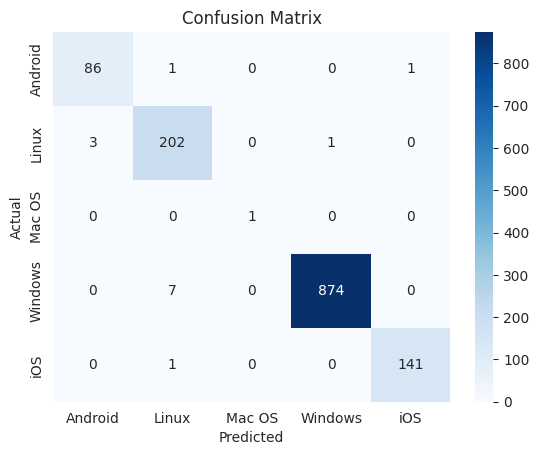

Accuracy: 0.9894
Precision: 0.9896
Recall: 0.9894
F1-score: 0.9894


In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

X_test_matrix = xgb.DMatrix(X_test, label=y_test)
y_pred = model.predict(X_test_matrix)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

<Figure size 3000x5000 with 0 Axes>

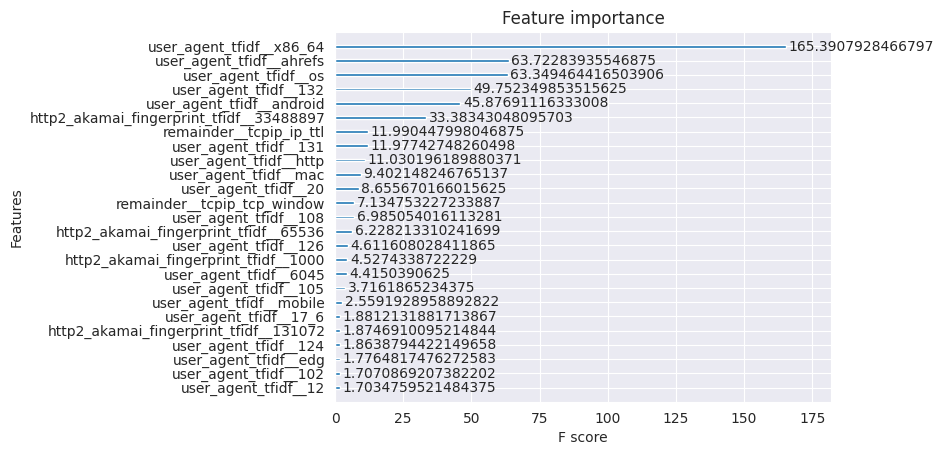

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30,50))
xgb.plot_importance(model, importance_type="gain", max_num_features=25)
plt.show()

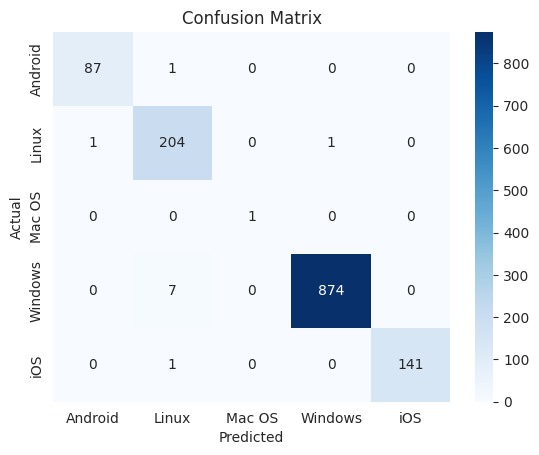

Accuracy: 0.9917
Precision: 0.9919
Recall: 0.9917
F1-score: 0.9917
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        88
           1       0.96      0.99      0.97       206
           2       1.00      1.00      1.00         1
           3       1.00      0.99      1.00       881
           4       1.00      0.99      1.00       142

    accuracy                           0.99      1318
   macro avg       0.99      0.99      0.99      1318
weighted avg       0.99      0.99      0.99      1318



In [30]:
X = X.drop(columns=['user_agent_tfidf__x86_64']) #data leakage????
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

dtrain = xgb.DMatrix(X_train, label=y_train)

new_model = xgb.train(params, dtrain, num_boost_round=70)

X_test_matrix = xgb.DMatrix(X_test, label=y_test)
y_pred = new_model.predict(X_test_matrix)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(classification_report(y_test, y_pred))

<Figure size 3000x5000 with 0 Axes>

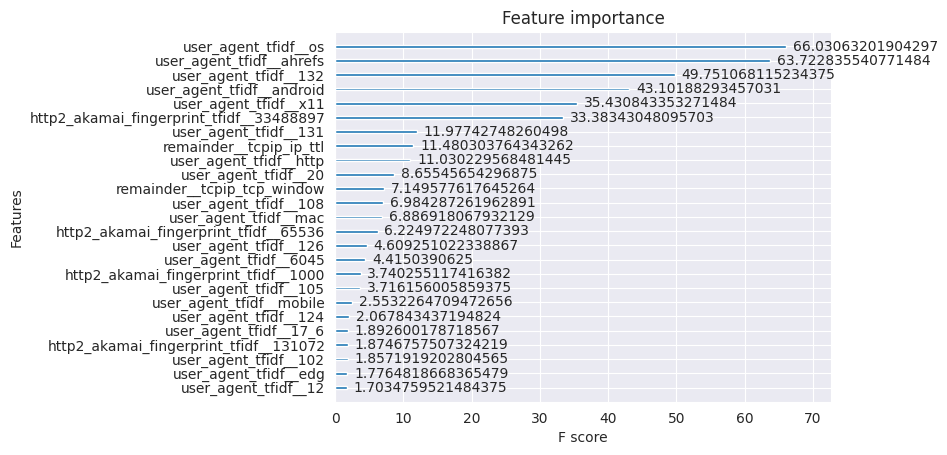

In [31]:
plt.figure(figsize=(30,50))
xgb.plot_importance(new_model, importance_type="gain", max_num_features=25)
plt.show()

In [32]:
import joblib

joblib.dump(model, '../models/xgb_1.pkl')
joblib.dump(new_model, "../models/xgb_2.pkl")    

['../models/xgb_2.pkl']